<h1><center>Ferramenta de suporte para marketing bancário<center></h1>
<p>Quem nuca recebeu um telefonema de um banco oferencendo um depósito a prazo? Essa é uma das formas como bancos 
fidelizam clientes e conseguem maior lucro.</p>
<p>Porém, essa atividade frequentemente necessita de uma grande equipe de call center que telefona para diversos cliente, 
e sabemos que a taxa de sucesso desses telefonemas são bem baixas.</p>
<p>Esse projeto se propõe a criar uma ferramenta que otimize esse processo. Se o banco sabe antecipadamente quais clientes são 
mais propícios a adquirir o serviço, pode-se focar a equipe de call center nesses clientes, aumentando a taxa de 
sucesso das ligações.</p>
    <p>Os dados usados estão no <a href="https://archive.ics.uci.edu/ml/datasets/bank+marketing">UCI Repository</a></p>
<p><b> Vamos aos dados!</b></p>

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import lightgbm
import xgboost
import hyperopt
from IPython.core.display import HTML
import itertools


def plot_confusion_matrix(cm, target_names, title='Matriz de Confusão',
                          cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)    

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto\nacurácia={:0.4f}; erro={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def DummyEnconde(df, col):
    dummies = pd.get_dummies(df[col],prefix=col, drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    df.drop([col],axis=1, inplace=True)
    
    return df

def categoryToNumberEncode(df, col, dic):
    df[col] = df[col].apply(lambda x: dic[x]).astype('int')
    return df


df = pd.read_csv("data/bank-data.csv", sep = ";")
target = 'y'

print('Número de linhas: {}'.format(df.shape[0]))
print('Número de atributos: {}'.format(df.shape[1]))

df.head()

Número de linhas: 41188
Número de atributos: 21


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<h2><center>Atributos</center></h2>
<p>Para melhor entender o problema, vamos ver quais são os atributos disponíveis.</p>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               40858 non-null object
marital           41108 non-null object
education         39457 non-null object
default           32591 non-null object
housing           40198 non-null object
loan              40198 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

<p>A partir dos dados acima, vemos que há 6 atributos com valores nulos, todos eles correspondem a informações pessoais dos clientes, são eles:</p>
<ul>
    <li>job (Ocupação)</li>
    <li>marital (Estado Civil)</li>
    <li>education (Escolaridade)</li>
    <li>default (Está inadimplente?)</li>
    <li>housing (Possui financiamento imobiliário?)</li>
    <li>loan (Possui empréstimo pessoal?)</li>
</ul>

In [8]:
display(HTML('<h3><center>Atributos Numéricos</center></h3>'))
display(df.describe())

display(HTML('<h3><center>Atributos Categóricos</center></h3>'))
display(df.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


<p>1) Observações sobre distribuição das colunas númericas:</p>
<ul>
    <li><b>Age (Idade):</b> Há clientes de 17 até 98 anos, com uma média de idade de 40 anos. Nada parece estranho com esse atributo.</li>
    <li><b>duration (duração do último contato em segundos):</b> Esse atributo deve ser excluído, pois só temos informação de duração da ligação depois que ela é feita. A ferramenta deve ser capaz de realizar a previsão de clientes promissores antes da ligação.</li>
    <li><b>campaign (Número de contatos realizados nessa campanha com esse cliente):</b> O valor máximo (56) destoa muito do resto da distribuição. Pode ser um valor anômalo, investigar melhor posteriormente</li>
    <li><b>pdays (dias passados desde o último contato na última campanha):</b> A grande maioria dos dados é 999, que significa que o cliente nunca foi contactado anteriormente. Investigar distribuição.</li>
    <li><b>previous (Número de contatos realizados antes dessa campanha):</b> Quase sempre parece ser 0. Investigar a distribuição.</li>
    <p>Os outros atributos numéricos são indicadores econômicos que parecem possuir valores dentro do esperado. Todos os atributos númericos não possuem valores nulos!</p>
</ul>

<p>2) Observações sobre distribuição das colunas categóricas:</p>
<ul>
    <p>Nenhum dos atributos possui uma cardinalidade muito alta (muitos valores únicos), o que facilitará a codificação deles.</p>
    <p>A grande maioria dos clientes nunca foi contatado (poutcome = nonexistent).</p>
    <p>Apenas 3 clientes estão inadimplentes (default = 'yes')! Atributo muito pouco informativo!</p>
    <p>6 atributos possuem valores inexistentes: job (ocupação), marital (Estado civil), education (escolaridade), default (está inadimplente), housing (tem empréstimo imobiliário) e loan (tem empréstimo pessoal). Estudar imputar dados onde for pertinente.</p>
</ul>

<h1>Análise Exploratória dos dados<h1>

<p>Buscando conhecer melhor os dados e o problema, vamos analisar os dados nesta seção. Levantar perguntas, e buscar responde-las utilizando os dados.</p>

<b>P: Qual é a taxa de sucesso atual das ligações do callcenter?</b>
<p>De todas as ligações, em torno de 11% resulta em venda do produto</p>

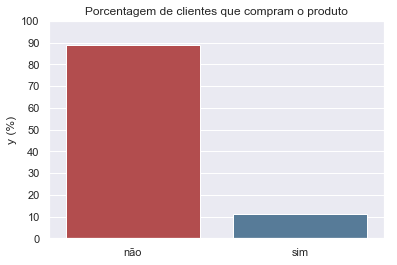

In [9]:
sns.set(style="darkgrid")

data = (df['y'].value_counts() *100) / len(df)
ax = sns.barplot(x=['não', 'sim'], y=data, palette="Set1", saturation=0.5)
_ = ax.set_title('Porcentagem de clientes que compram o produto')
_ = ax.set_ylabel('y (%)')
_ = ax.set_ylim([0,100])
_ = ax.set_yticks(range(0,101,10))

<b>P: Clientes de uma forma geral estão mais dispostos a adiquirir o produto em algum dia da semana? E em algum mês em específico?</b>
<p>A variação ao longo da semana é maior, mas o mau humor da segunda-feira parece deixar as pessoas menos dispostas! Nos meses, é visível que os clientes estão muito mais dipostos a adiquirir esses serviços no início e fim do ano (com exceção de novembro) do que no meio do ano.</p>    

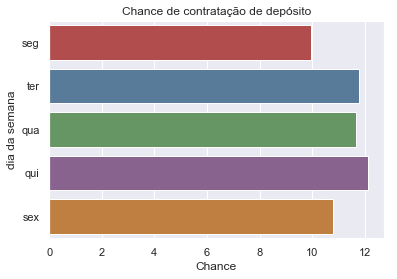

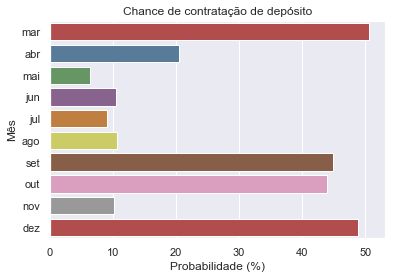

In [10]:
#Transforma variável a ser prevista em numérica
df['y'] = df['y'].replace({'no':0, 'yes':1})

data = df[['day_of_week','y']].groupby(['day_of_week']).mean()
data = data.reindex(['mon', 'tue', 'wed', 'thu', 'fri'])
dias = ['seg', 'ter', 'qua', 'qui', 'sex']
ax = sns.barplot(y=dias, x=data['y']*100, palette="Set1", saturation=0.5)
_ = ax.set_title('Chance de contratação de depósito')
_ = ax.set_ylabel('dia da semana')
_ = ax.set_xlabel('Chance')
plt.show()

data = df[['month','y']].groupby(['month']).mean()
data = data.reindex(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
meses = ['mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
ax = sns.barplot(y=meses, x=data['y']*100, palette="Set1", saturation=0.5)
_ = ax.set_title('Chance de contratação de depósito')
_ = ax.set_ylabel('Mês')
_ = ax.set_xlabel('Probabilidade (%)')
plt.show()

<b>P: Pessoas inadimplentes tendem a ter uma menor chance de comprar o produto? E as que possuem algum empréstimo já feito?</b>
<p>O fato de ter um empréstimo pessoal ou imobiliário feito, não parece influenciar muito na decisão do cliente de forma geral. Pessoas não inadimplentes parecem mais propícias a comprar o produto, porém só há 3 pessoas inadiplentes no conjunto de dados, o que impossibilita afirmar algo sobre elas com base na estatística dos dados.</p>

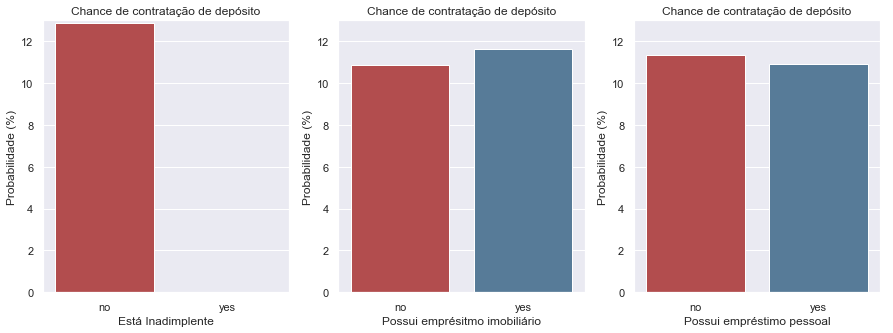

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

data = df[['default','y']].groupby(['default']).mean()
sns.barplot(x=data.index, y=data['y']*100, palette="Set1", saturation=0.5, ax=ax1)
_ = ax1.set_title('Chance de contratação de depósito')
_ = ax1.set_xlabel('Está Inadimplente')
_ = ax1.set_ylabel('Probabilidade (%)')
_ = ax1.set_ylim([0,13])

data = df[['housing','y']].groupby(['housing']).mean()
sns.barplot(x=data.index, y=data['y']*100, palette="Set1", saturation=0.5, ax=ax2)
_ = ax2.set_title('Chance de contratação de depósito')
_ = ax2.set_xlabel('Possui emprésitmo imobiliário')
_ = ax2.set_ylabel('Probabilidade (%)')
_ = ax2.set_ylim([0,13])

data = df[['loan','y']].groupby(['loan']).mean()
sns.barplot(x=data.index, y=data['y']*100, palette="Set1", saturation=0.5, ax=ax3)
_ = ax3.set_title('Chance de contratação de depósito')
_ = ax3.set_xlabel('Possui empréstimo pessoal')
_ = ax3.set_ylabel('Probabilidade (%)')
_ = ax3.set_ylim([0,13])

<b>P: Dentre os meios de contato, algum é mais efetivo?</b>
<p>É muito mais fácil uma pessoa adquirir o produto quando contatada pelo celular, isso pode ocorrer pois em ligações para telefone fixo pode ser comum a pessoa não estar em casa</p>

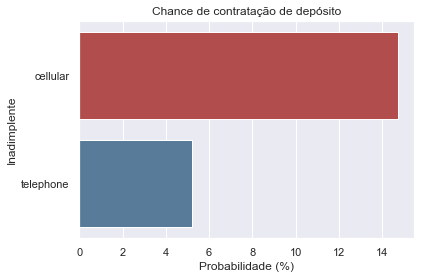

In [12]:
#Transforma variável a ser prevista em nuérica
data = df[['contact','y']].groupby(['contact']).mean()
ax = sns.barplot(y=data.index, x=data['y']*100, palette="Set1", saturation=0.5)
_ = ax.set_title('Chance de contratação de depósito')
_ = ax.set_ylabel('Inadimplente')
_ = ax.set_xlabel('Probabilidade (%)')

<b>P: Um cliente já ter adquirido o produto em uma campanha passada aumenta as chances de ele adquirir nessa também?</b>
<p> Sim! clientes que adiquiriram o produto em campanhas passadas tem uma probabilidade de adquirirem o serviço de novo muito maior. Além disso, clientes que já foram contatos em campanhas anteriores, ainda que não tenham contratado o servioç, possuem uma maior probabilidade de contratarem nessa campanha do que os que nunca foram contatados.</p>

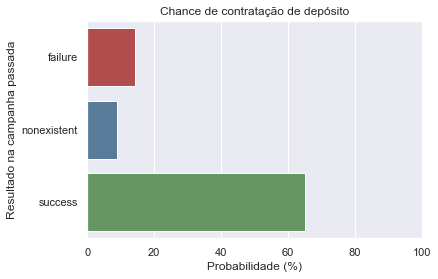

In [13]:
data = df[['poutcome','y']].groupby(['poutcome']).mean()
ax = sns.barplot(y=data.index, x=data['y']*100, palette="Set1", saturation=0.5)
_ = ax.set_title('Chance de contratação de depósito')
_ = ax.set_ylabel('Resultado na campanha passada')
_ = ax.set_xlabel('Probabilidade (%)')
_ = ax.set_xlim([0,100])

<b>P: Quais níveis de escolaridade são mais comuns? E quais níveis de escolaridade são mais propensos a adquirir o produto?</b>
<p>Pessoas com ensino médio completo ou com diploma universitário são as mais comuns no conjunto de dados. De todas as escolaridades, a que parece mais fácil de convencer são pessoas analfabetas, porém no gráfico da esquerda fica claro que há poucas pessoas iletradas no conjunto de dados, e por isso não há certeza se pessoas iletradas de fatos costumam ter 20% de chance de adquirir o produto. Dentre as outras escolaridades, pessoas com diploma universitário são as mais comuns de adquirirem o produto.</p>

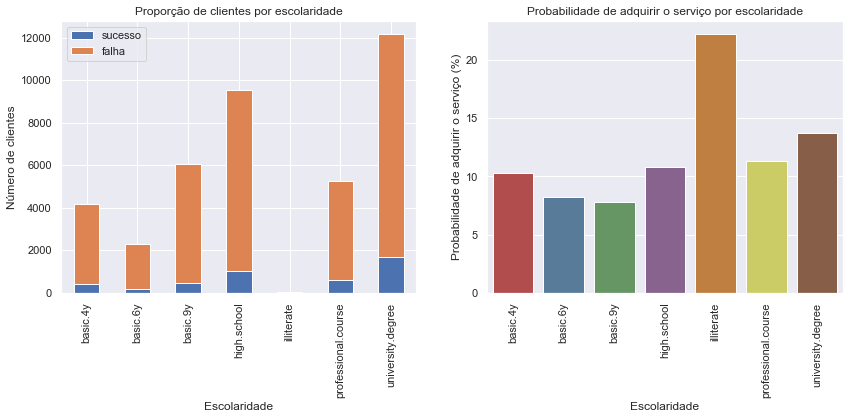

In [14]:
data_sucesso = df.loc[df['y'] == 1, ['education','y']].groupby(['education']).count()
data_falha = df.loc[df['y'] == 0, ['education','y']].groupby(['education']).count()

data = pd.DataFrame(index=['sucesso','falha'],columns=data_sucesso.index)
data.loc['sucesso', :] = data_sucesso.values.reshape(1,-1)
data.loc['falha', :] = data_falha.values.reshape(1,-1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Plot 1
data.T.plot(kind='bar', stacked=True, ax=ax1)
_ = ax1.set_title('Proporção de clientes por escolaridade')
_ = ax1.set_ylabel('Número de clientes')
_ = ax1.set_xlabel('Escolaridade')

# Plot 2
data = df[['education','y']].groupby(['education']).mean()
sns.barplot(x=data.index, y=data['y']*100, palette="Set1", saturation=0.5, ax=ax2)
plt.xticks(rotation=90)
_ = ax2.set_title('Probabilidade de adquirir o serviço por escolaridade')
_ = ax2.set_ylabel('Probabilidade de adquirir o serviço (%)')
_ = ax2.set_xlabel('Escolaridade')

<h2>Imputando Valores Vazios</h2>

<p>Lembrando que há 6 atributos com valores inexistentes: job (ocupação), marital (Estado civil), education (escolaridade), default (está inadimplente), housing (tem empréstimo imobiliário) e loan (tem empréstimo pessoal). Estudar imputar dados onde for pertinente. A análise para imputação será feita individualmente para cada atributo.

<li>education (escolaridade)</li>
<p>Imputar a escolaridade mais comum da profissão em questão. Caso não tenha profissão, a escolaridade será uma nova classe, nomeada 'desconhecido'.

In [15]:
def valoresNulos(col):    
    nulos = df[col].isna().sum()
    porcentagem = (nulos * 100) / len(df)
    return porcentagem, nulos

porcentagem, nulos = valoresNulos('education')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

escolaridades_por_profissao = dict()
for job in df['job'].unique():
    if job is not np.nan:
        escolaridades_por_profissao[job] = df.loc[df['job'] == job, 'education'].value_counts().index[0]
        
nao_tem_profissao_e_escolaridade = (df['education'].isna() & df['job'].isna())
df.loc[nao_tem_profissao_e_escolaridade, 'education'] = 'desconhecido'

nao_tem_escolaridade = df['education'].isna()
df.loc[nao_tem_escolaridade, 'education'] = df.loc[nao_tem_escolaridade, 'job']\
                                            .apply(lambda job: escolaridades_por_profissao[job])

print('\nImputação conluída para education. Resultado:')
porcentagem, nulos = valoresNulos('education')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

Porcentagem de valores nulos: 4.20% (1731 instâncias)

Imputação conluída para education. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)


<li>job (ocupação)</li>
<p>Como há muitas ocupações diferentes, é arriscado imputar o valor mais comum. Logo, criar uma terceira classe de ocupação chamado 'desconhecido'.</p>

In [16]:
porcentagem, nulos = valoresNulos('job')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))


print(df['job'].value_counts() / df['job'].notnull().sum())

df['job'] = df['job'].fillna('desconhecido')

print('\nImputação conluída para job. Resultado:')
porcentagem, nulos = valoresNulos('job')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

Porcentagem de valores nulos: 0.80% (330 instâncias)

admin.           0.255079
blue-collar      0.226492
technician       0.165035
services         0.097141
management       0.071565
retired          0.042097
entrepreneur     0.035636
self-employed    0.034779
housemaid        0.025944
unemployed       0.024818
student          0.021416
Name: job, dtype: float64

Imputação conluída para job. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)


<li>marital (Estado civil)</li>
<p> Imputar estado civil baseado na idade. Cada estado civil possui uma média de idade, então para cada cliente, imputar o estado civil cuja idade média é a mais próxima da idade do cliente. </p>

In [17]:
porcentagem, nulos = valoresNulos('marital')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))

print('Média de idade por estado civil')
media_por_idade = df[['marital', 'age']].groupby('marital').mean()
display(media_por_idade)

def ImputarEstadoCivilPelaIdade(media, value):
    array = np.asarray(media['age'].values)
    idx = (np.abs(array - value)).argmin()
    return media_por_idade.index[idx]

nao_tem_estado_civil = df['marital'].isna()
df.loc[nao_tem_estado_civil, 'marital'] = df['age'].apply(lambda age: ImputarEstadoCivilPelaIdade(media_por_idade, age))

print('\nImputação conluída para marital. Resultado:')
porcentagem, nulos = valoresNulos('marital')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))

Porcentagem de valores nulos: 0.19% (80 instâncias)

Média de idade por estado civil


,age
marital,
divorced,44.899393
married,42.307165
single,33.158714



Imputação conluída para marital. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)



<li>default (está inadimplente)</li>
<p>Possui 2 classes ('sim' ou 'não'). Pessoas inadimplentes são extremamente raras no conjunto de dados (apenas 3). Possui uma grande quantidade de valores nulos, que podem ser descritivos, então criaremos uma nova classe chamada 'desconhecido'.</p>

In [18]:
porcentagem, nulos = valoresNulos('default')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))

print(df['default'].value_counts())

df['default'] = df['default'].fillna('desconhecido')

print('\nImputação conluída para default. Resultado:')
porcentagem, nulos = valoresNulos('marital')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))

Porcentagem de valores nulos: 20.87% (8597 instâncias)

no     32588
yes        3
Name: default, dtype: int64

Imputação conluída para default. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)



<li>housing (tem empréstimo imobiliário)</li>
<p>Nenhum outro atributo parece ter uma correlação significativa e que possa ser explorada. ALém disso, ter um não um emprétimo imobiliário é quase igualmente comum no conjunto de dados. Logo, criar uma terceira classe 'desconhecido' para valores inexistentes.</p>

In [19]:
porcentagem, nulos = valoresNulos('housing')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)\n'.format(porcentagem, nulos))

print(df['housing'].value_counts() / df['housing'].notnull().sum())

df['housing'] = df['housing'].fillna('desconhecido')

print('\nImputação conluída para housing. Resultado:')
porcentagem, nulos = valoresNulos('housing')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

Porcentagem de valores nulos: 2.40% (990 instâncias)

yes    0.536743
no     0.463257
Name: housing, dtype: float64

Imputação conluída para housing. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)


<li>loan (tem empréstimo pessoal)</li>
<p>Criaremos uma nova classe 'desconhecido' para imputar os dado.</p>

In [20]:
porcentagem, nulos = valoresNulos('loan')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

print(df['loan'].value_counts() / df['loan'].notnull().sum())

df['loan'] = df['loan'].fillna('desconhecido')

print('\nImputação conluída para loan. Resultado:')
porcentagem, nulos = valoresNulos('loan')
print('Porcentagem de valores nulos: {:.2f}% ({} instâncias)'.format(porcentagem, nulos))

Porcentagem de valores nulos: 2.40% (990 instâncias)
no     0.844569
yes    0.155431
Name: loan, dtype: float64

Imputação conluída para loan. Resultado:
Porcentagem de valores nulos: 0.00% (0 instâncias)


<h2>Codificando Atributos</h2>

In [21]:
def PreprocessarAtributos(df):
    education_dic = {'illiterate':0, 'basic.4y':1, 
                     'basic.6y':2, 'basic.9y':3, 
                     'high.school':4, 'professional.course':5, 
                     'university.degree':6, 'desconhecido':-1}
    education_dic = {'illiterate':0, 'basic.4y':1, 
                     'basic.6y':2, 'basic.9y':3, 
                     'high.school':4, 'professional.course':5, 
                     'university.degree':6, 'desconhecido':-1}
    marital_dic = {'single':0, 'married':1, 
                   'divorced':2, 'desconhecido':-1}
    contact_dic = {'telephone':0, 'cellular':1}
    week_dic = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}
    month_dic = {'jan':1, 'fev': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
                'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    other_dic = {'yes':1, 'no':0, 'desconhecido':-1}

    df = df.fillna('desconhecido')    

    df = DummyEnconde(df, 'job')
    df = categoryToNumberEncode(df, 'marital', marital_dic)
    df = categoryToNumberEncode(df, 'education', education_dic)
    df = categoryToNumberEncode(df, 'default', other_dic)
    df = categoryToNumberEncode(df, 'housing', other_dic)
    df = categoryToNumberEncode(df, 'loan', other_dic)
    df = categoryToNumberEncode(df, 'contact', contact_dic)
    df = categoryToNumberEncode(df, 'month', month_dic)
    df = categoryToNumberEncode(df, 'day_of_week', week_dic)
    df = DummyEnconde(df, 'poutcome')
    df = df.drop(columns=['duration'])
    return df

df = PreprocessarAtributos(df)
display(df.head())

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,poutcome_nonexistent,poutcome_success
0,56,1,1,0,0,0,0,5,1,1,...,1,0,0,0,0,0,0,0,1,0
1,57,1,4,-1,0,0,0,5,1,1,...,0,0,0,0,1,0,0,0,1,0
2,37,1,4,0,1,0,0,5,1,1,...,0,0,0,0,1,0,0,0,1,0
3,40,1,2,0,0,0,0,5,1,1,...,0,0,0,0,0,0,0,0,1,0
4,56,1,4,0,0,1,0,5,1,1,...,0,0,0,0,1,0,0,0,1,0


<h2>Interação entre atributos</h2>

<p>Foram excluídos da matriz atributos que não possui correlação maior que 0.3 ou menor que -0.3 com nenhum outro atributo para facilitar a visualização.</p>
<p>Os atributos mais fortemente correlacionados são 4 dos indicadores econômicos e sociais (emp.var.rate, cons.price.idx,  euribor3m, nr.employed). Para não comprometer o desempenho de modelos preditivos e a interpretabilidade dos atributos, é desejável excluir atributos redundantes. Portanto, serão removidos 2 atributos: nr.employed (número de pessoas empregadas) e cons.price.idx (Índice de preços no consumidor).</p>

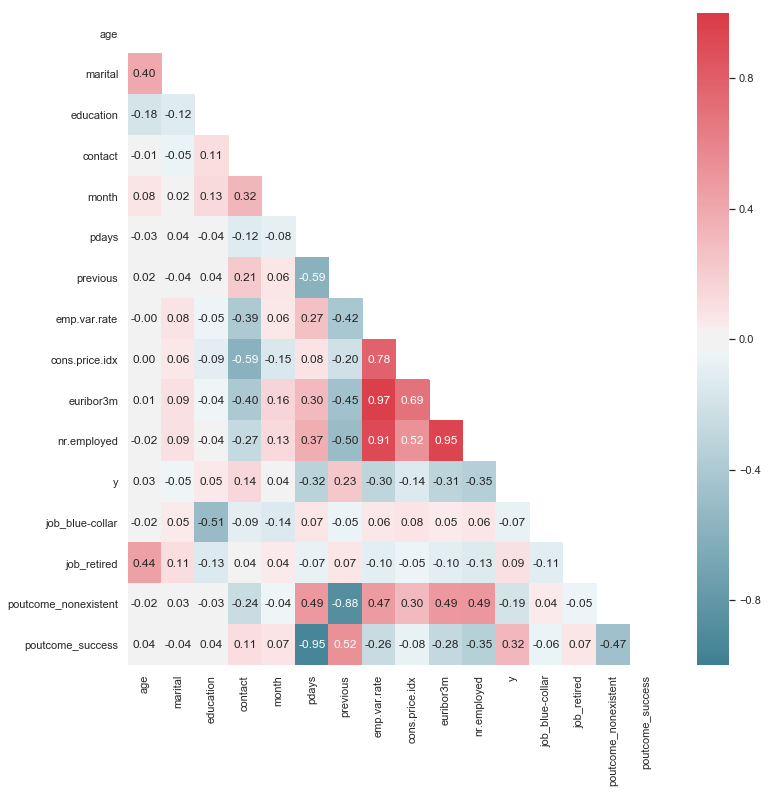


2 atributos deletados: nr.employed e cons.price.idx


In [22]:
corr = df.corr()

limiar = 0.3
for c in corr.columns:
    if (corr[c].drop(c).abs().max()<= limiar):
        corr = corr.drop(index=c, columns=c)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
fig, ax = plt.subplots(figsize=(12, 12),facecolor='white')
colormap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, cmap=colormap, annot=True, fmt='.2f')
plt.show()

print('\n2 atributos deletados: nr.employed e cons.price.idx')
df = df.drop(columns=['nr.employed','cons.price.idx'])

<h2>Modelos Preditivos</h2>
A métrica adotada para a tunagem de parâmetros foi a sensibilidade (recall). Pois nesse problema, o mais importante é que todos os clientes que comprem o produto sejam identificados, ainda que alguns sejam falso positivos.

In [23]:
cols = [c for c in df.columns if c != target]
X = df[cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
df.columns
display(X_train.head())

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,poutcome_nonexistent,poutcome_success
39075,29,1,6,0,0,0,1,12,1,3,...,0,0,0,0,0,0,0,0,0,0
34855,29,0,6,0,0,0,0,5,5,4,...,0,0,0,0,0,0,1,0,1,0
7107,45,1,2,-1,1,0,0,5,4,2,...,0,0,0,0,0,0,0,0,1,0
31614,34,1,6,0,0,0,1,5,4,1,...,0,0,0,0,1,0,0,0,0,0
34878,32,0,4,0,0,0,1,5,5,9,...,0,0,0,0,0,0,0,0,1,0


<h3>Logistic Regression</h3>
<p>O modelo de Regressão Logística é um modelo linear generalizado simples para classificação. Como possui poucos hiper-parâmetros, será tunado com uma técnica de busca exaustiva (grid search).</p>

In [24]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train_log = scaler.transform(X_train)
X_test_log = scaler.transform(X_test)

pipe = Pipeline([('classifier' , LogisticRegression())])

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},    
]

kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
clf = GridSearchCV(pipe, param_grid = param_grid, scoring='recall', refit=True, 
                   cv = kfold, n_jobs=3)

clf.fit(X_train_log, y_train)
#display(clf.get_params)

lg = clf.best_estimator_
print('Recall-score (Sensibilidade) do melhor modelo: {}'.format(clf.best_score_))

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Recall-score (Sensibilidade) do melhor modelo: 0.19981740389799366


<h3>LightGBM</h3>
<p>O modelo LightGBM é um eficiente algoritmo de gradient boosting, com a habilidade de tratar melhor atributos categóricos e um dos mais rápidos desse tipo. Para a tunagem, utilizamos otimzação bayesiana, ma vez que o LightGBM possui um grande número de hiper-parâmetros a serem tunados.</p>

In [25]:
cols_categorical = ['marital', 'education', 'default', 'housing', 'loan', 'contact',
                   'month', 'day_of_week','job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                   'job_management', 'job_retired', 'job_self-employed', 'job_services',
                   'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
                   'poutcome_nonexistent', 'poutcome_success']

def otimizarParametrosLightgbm(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    lgbm = lightgbm.LGBMClassifier(objective='binary', n_estimators=200, category_feature=cols_categorical, 
                                   importance_type='gain', **params)
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
    cv = cross_val_score(lgbm, X_train, y_train, scoring='recall', 
                         cv=kfold, n_jobs=3, verbose=0)
    return -cv.mean()

space = {
        'num_leaves': hyperopt.hp.quniform('num_leaves', 30, 150, 1),
        'class_weight': hyperopt.hp.choice('class_weight', [None, 'balanced']),
        'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hyperopt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'min_child_samples': hyperopt.hp.quniform('min_child_samples', 20, 500, 5),
        'reg_alpha': hyperopt.hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hyperopt.hp.uniform('reg_lambda', 0.0, 1.0),
        }


best_lgbm_params = hyperopt.fmin(fn=otimizarParametrosLightgbm,
                                  space=space,
                                  algo=hyperopt.tpe.suggest,
                                  max_evals=100)

100%|████████████████████████████████████████████████| 100/100 [16:18<00:00,  8.69s/it, best loss: -0.6589402339595888]


In [26]:
class_weight_options = [None, 'balanced']
try:
    best_lgbm_params['num_leaves'] = int(best_lgbm_params['num_leaves'])
    best_lgbm_params['min_child_samples'] = int(best_lgbm_params['min_child_samples'])
    best_lgbm_params['class_weight'] = class_weight_options[best_lgbm_params['class_weight']]
except:
    pass

lgbm = lightgbm.LGBMClassifier(objective='binary', n_estimators=200, category_feature=cols_categorical, 
                               importance_type='gain', **best_lgbm_params)

lgbm = lgbm.fit(X_train, y_train)                               

print('Fim do treino do LightGBM!')

Fim do treino do LightGBM!


<h3>XGBoost</h3>
<p>Um outro algoritmo de trees gradient boosting, que tem um avançado tratamento de valores nulos. Também foi utilizado otimzação bayesiana para tunagem de hiper-parâmetros.</p>

In [27]:
def otimizarParametrosXGBoot(params):
    params['max_depth'] = int(params['max_depth'])
    
    xgb = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=150, 
                                missing=-1, tree_method='hist', **params)
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
    cv = cross_val_score(xgb, X_train, y_train, scoring='recall', 
                         cv=kfold, n_jobs=3, verbose=0)
    return -cv.mean()

space = {
    'learning_rate': hyperopt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': hyperopt.hp.quniform('max_depth', 3, 8, 1),
    'min_child_weight': hyperopt.hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hyperopt.hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hyperopt.hp.uniform('gamma', 0.0, 0.5),
    'scale_pos_weight': hyperopt.hp.uniform('scale_pos_weight', 4, 12),
    'reg_alpha': hyperopt.hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hyperopt.hp.uniform('reg_lambda', 0.0, 1.0)
}


best_xgb_params = hyperopt.fmin(fn=otimizarParametrosXGBoot,
                                  space=space,
                                  algo=hyperopt.tpe.suggest,
                                  max_evals=100)

100%|████████████████████████████████████████████████| 100/100 [21:33<00:00, 11.32s/it, best loss: -0.7200235377525701]


In [28]:
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])

xgb = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=150, 
                             missing=-1, tree_method='hist', **best_xgb_params)

xgb = xgb.fit(X_train, y_train)
                            
print('Fim do treino do XGBoost!')

[19:27:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fim do treino do XGBoost!


<h2>Comparação dos modelos nos dados de treino</h2>

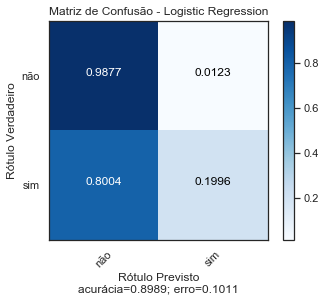

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     25580
           1       0.67      0.20      0.31      3251

   micro avg       0.90      0.90      0.90     28831
   macro avg       0.79      0.59      0.63     28831
weighted avg       0.88      0.90      0.87     28831



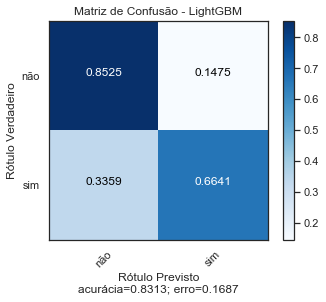

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     25580
           1       0.36      0.66      0.47      3251

   micro avg       0.83      0.83      0.83     28831
   macro avg       0.66      0.76      0.68     28831
weighted avg       0.89      0.83      0.85     28831



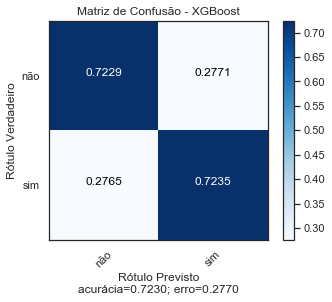

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     25580
           1       0.25      0.72      0.37      3251

   micro avg       0.72      0.72      0.72     28831
   macro avg       0.60      0.72      0.60     28831
weighted avg       0.87      0.72      0.77     28831



In [29]:
lg_pred = lg.predict(X_train_log)
lgbm_pred = lgbm.predict(X_train)
xgb_pred = xgb.predict(X_train)


display(HTML("<h4>Logistic Regression</h4>"))
cm_lg = confusion_matrix(y_train, lg_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - Logistic Regression')
print(classification_report(y_train, lg_pred))

display(HTML("<h4>LightGBM</h4>"))
cm_lg = confusion_matrix(y_train, lgbm_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - LightGBM')
print(classification_report(y_train, lgbm_pred))

display(HTML("<h4>XGBoost</h4>"))
cm_lg = confusion_matrix(y_train, xgb_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - XGBoost')
print(classification_report(y_train, xgb_pred))


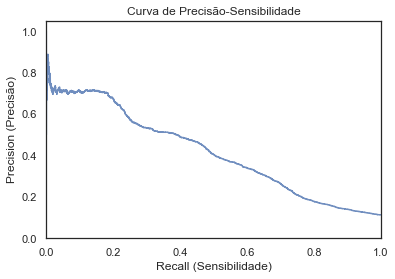

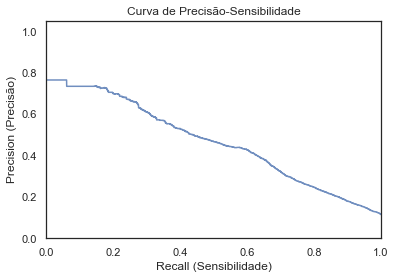

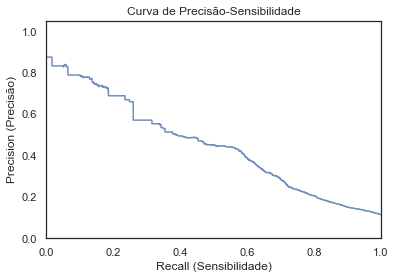

In [30]:
def plotPrecisionRecallCurve(model, x, y):
    y_pred = model.predict_proba(x)[:,1]
    precision, recall, limiar = precision_recall_curve(y, y_pred)

    plt.step(recall, precision, color='b', alpha=0.8, where='post')

    plt.xlabel('Recall (Sensibilidade)')
    plt.ylabel('Precision (Precisão)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Curva de Precisão-Sensibilidade')
    plt.show()
    
    return precision, recall, limiar

display(HTML("<h4>Logistic Regression</h4>"))
precision_lg, recall_lg, limiar_lg = plotPrecisionRecallCurve(lg, X_train_log, y_train)

display(HTML("<h4>LightGBM</h4>"))
precision_lgbm, recall_lgbm, limiar_lgbm = plotPrecisionRecallCurve(lgbm, X_train, y_train)

display(HTML("<h4>XGBoost</h4>"))
precision_xgb, recall_xgb, limiar_xgb = plotPrecisionRecallCurve(xgb, X_train, y_train)

<p>Vamos definir valores de limiares para cada modelo de forma que atendam a uma sensibilidade mínima de 75%</p>

In [31]:
def definiarLimiar(recall, precision, limiares, minRecall):
    ind = (recall >= minRecall).argmin() - 1
    
    print("Precisão do modelo: {:.4f}".format(precision[ind]))
    print("Sensibilidade do modelo: {:.4f}".format(recall[ind]))
    print("Limiar do modelo: {:.4f}".format(limiares[ind]))
    
    return limiares[ind]

minRecall = 0.75

display(HTML("<h4>Logistic Regression</h4>"))
limiar_lg = definiarLimiar(recall_lg, precision_lg, limiar_lg, minRecall)

display(HTML("<h4>LightGBM</h4>"))
limiar_lgbm = definiarLimiar(recall_lgbm, precision_lgbm, limiar_lgbm, minRecall)

display(HTML("<h4>XGBoost</h4>"))
limiar_xgb = definiarLimiar(recall_xgb, precision_xgb, limiar_xgb, minRecall)


Precisão do modelo: 0.2097
Sensibilidade do modelo: 0.7502
Limiar do modelo: 0.0684


Precisão do modelo: 0.2763
Sensibilidade do modelo: 0.7502
Limiar do modelo: 0.4032


Precisão do modelo: 0.2345
Sensibilidade do modelo: 0.7508
Limiar do modelo: 0.4498


<p>Avaliando as curvas de Precisão-Sensibilidade de cada modelo e o cálculo acima, percebe-se que com uma sensibilidade mínima de 0.75, o que consegue manter maior precisão é o modelo LightGBM.</p> 
<p>A métrica de sensibilidade é mais importante que precisão nesse caso, pois ligar para um cliente que não acaba não adquirindo o produto (baixa precisão) tem um custo muito menor que deixar de ligar para um cliente que iria adquirir o produto (baixa sensibilidade).</p>
<p>Sendo assim, recomenda-se, que sempre que um cliente tiver uma probabilidade igual ou maior a 40.24% de comprar o produto segundo o modelo, o call center deve tentar ligar!</p>
<p>Abaixo os modelos são reavalidos segundo a probabilidade limiar definida para cada modelo.</p>

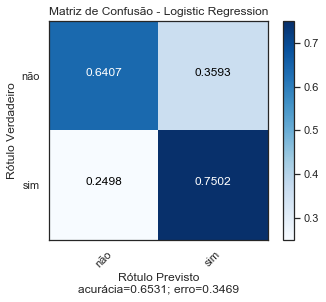

              precision    recall  f1-score   support

           0       0.95      0.64      0.77     25580
           1       0.21      0.75      0.33      3251

   micro avg       0.65      0.65      0.65     28831
   macro avg       0.58      0.70      0.55     28831
weighted avg       0.87      0.65      0.72     28831



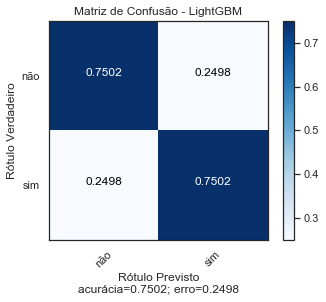

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     25580
           1       0.28      0.75      0.40      3251

   micro avg       0.75      0.75      0.75     28831
   macro avg       0.62      0.75      0.62     28831
weighted avg       0.88      0.75      0.79     28831



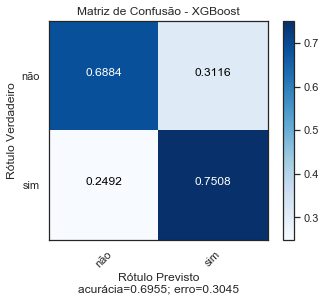

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     25580
           1       0.23      0.75      0.36      3251

   micro avg       0.70      0.70      0.70     28831
   macro avg       0.60      0.72      0.58     28831
weighted avg       0.87      0.70      0.75     28831



In [32]:
def predizerComLimiar(model, x, limiar):
    y_prob = model.predict_proba(x)[:,1]
    return (y_prob >= limiar)

lg_pred = predizerComLimiar(lg, X_train_log, limiar_lg)
lgbm_pred = predizerComLimiar(lgbm, X_train, limiar_lgbm)
xgb_pred = predizerComLimiar(xgb, X_train, limiar_xgb)


display(HTML("<h4>Logistic Regression</h4>"))
cm_lg = confusion_matrix(y_train, lg_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - Logistic Regression')
print(classification_report(y_train, lg_pred))

display(HTML("<h4>LightGBM</h4>"))
cm_lg = confusion_matrix(y_train, lgbm_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - LightGBM')
print(classification_report(y_train, lgbm_pred))

display(HTML("<h4>XGBoost</h4>"))
cm_lg = confusion_matrix(y_train, xgb_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - XGBoost')
print(classification_report(y_train, xgb_pred))


<h2>Comparação dos modelos em teste e Conclusão</h2>

<p>Utilizando os limiares definidos, vamos checar o desempenho de cada modelo nos dados de teste para escolher o modelo final.</p>
<p>Apesar de resultados próximos, escolheria o modelo <b>XGBoost</b>, que em teste manteve uma sensibilidade de 0.74 e uma precisão de 0.22.</p>
<p> Sendo assim, concluo que com a incorporação do modelo, utilizando um limiar de 44.98%, o modelo acertaria 69.44% das ligações se ela resultaria em compra do produto ou não. De todas as vezes que o modelo aconselhasse a ligação 23% das vezes de fato resultaria em compra (um pouco mais que o dobro de compra que havia antes da implantação do modelo). Já quando o modelo não aconselhasse a ligação, 95% de fato não resultaria em compra do produto.</p>

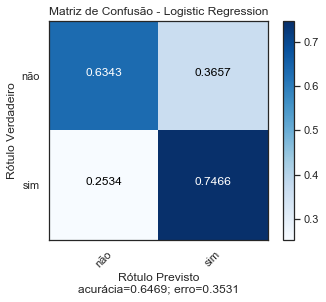

              precision    recall  f1-score   support

           0       0.95      0.63      0.76     10968
           1       0.21      0.75      0.32      1389

   micro avg       0.65      0.65      0.65     12357
   macro avg       0.58      0.69      0.54     12357
weighted avg       0.87      0.65      0.71     12357



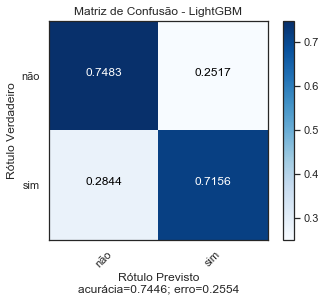

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     10968
           1       0.26      0.72      0.39      1389

   micro avg       0.74      0.74      0.74     12357
   macro avg       0.61      0.73      0.61     12357
weighted avg       0.88      0.74      0.79     12357



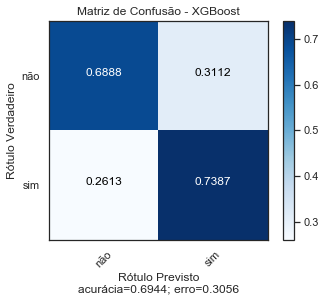

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10968
           1       0.23      0.74      0.35      1389

   micro avg       0.69      0.69      0.69     12357
   macro avg       0.59      0.71      0.58     12357
weighted avg       0.87      0.69      0.75     12357



In [33]:
def predizerComLimiar(model, x, limiar):
    y_prob = model.predict_proba(x)[:,1]
    return (y_prob >= limiar)

lg_pred = predizerComLimiar(lg, X_test_log, limiar_lg)
lgbm_pred = predizerComLimiar(lgbm, X_test, limiar_lgbm)
xgb_pred = predizerComLimiar(xgb, X_test, limiar_xgb)

display(HTML("<h4>Logistic Regression</h4>"))
cm_lg = confusion_matrix(y_test, lg_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - Logistic Regression')
print(classification_report(y_test, lg_pred))

display(HTML("<h4>LightGBM</h4>"))
cm_lg = confusion_matrix(y_test, lgbm_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - LightGBM')
print(classification_report(y_test, lgbm_pred))

display(HTML("<h4>XGBoost</h4>"))
cm_lg = confusion_matrix(y_test, xgb_pred)
plot_confusion_matrix(cm_lg, ['não', 'sim'], title='Matriz de Confusão - XGBoost')
print(classification_report(y_test, xgb_pred))


<h2>Importância dos Atributos</h2>

<p>Pelo gráfico, percebemos que alguns atributos foram considerados sem importância pelo modelo. Os atributos referentes ao trabalho do cliente foram quase todos ignorados ou tiveram importância muito baixa.</p>
<p>o atributo 'euribor3m' é um indicador econômico que tende a ter influência na taxa de juros no contexto Europeu referente a esse conjunto de dados.</p>
<p>De forma geral, podemos concluir que os atributos que representam o contexto econômico e social são os fatores mais importantes para a decisão de compra do produto do cliente. Porém, alguns outros fatores dentro do controle do banco também possuem significativa importância. Como o número de dias passados desde a última ligação na campanha anterior (pdays), o número de vezes que foi entrado em contato nessa campanha (campaign), a forma de contato com o cliente (contact) e até a idade do cliente (age).</p>

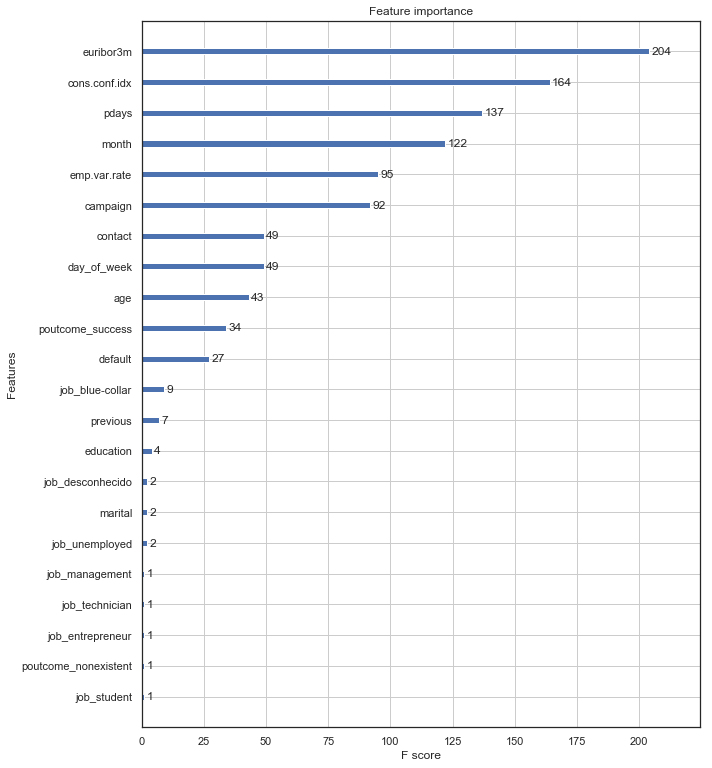

In [44]:
fig = plt.figure(figsize=(10,13))
ax = fig.add_subplot(1, 1, 1)
xgboost.plot_importance(xgb, ax=ax)
plt.show()